In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
#import seaborn as sns 
%matplotlib inline
import lammps_logfile
import warnings
warnings.filterwarnings("ignore")
import re

In [2]:

#function to calculate displacements-per-atom (dpa)
def DPA(E,npka,estop,n,TDE):
    #input E:recoil energy
    #npka:cascade times
    #estop:electronic stopping power,obtained by lammps logfile output stable 'f_elstop'
    #n:number of atoms
    #TDE: lattice dis-placement energy
    #output: dpa value
    Td=E-estop
    return npka*0.8*Td/(2*TDE*n)

In [3]:
TDEO1=16.69665071770335
TDEO2=17.730616302186878
TDEO3=16.35593220338983
TDEGa1=22.164750957854405
TDEGa2=19.410679611650487
mO=15.9994
mGa=69.72
TDEga2o3=((TDEO1+TDEO2+TDEO3)*mO+(TDEGa1+TDEGa2)*mGa)/(2*mGa+3*mO)
TDEga2o3

19.79927110353614

In [4]:
pkal=[0,100,155,200,500,1000,1500,2000,2200]
dpa=np.zeros(len(pkal))
for i in range(len(pkal)):
    dpa[i]=DPA(1500,pkal[i],193.294,81920,TDEga2o3)
dpa

array([0.        , 0.03222543, 0.04994942, 0.06445086, 0.16112715,
       0.32225431, 0.48338146, 0.64450861, 0.70895948])

In [5]:
pkal=[300,600,900,1200,1500,1800,1900,2000,2100,2400,2700,3000]
dpa=np.zeros(len(pkal))
for i in range(len(pkal)):
    dpa[i]=DPA(1500,pkal[i],193.294,81920,TDEga2o3)
dpa

array([0.09667629, 0.19335258, 0.29002888, 0.38670517, 0.48338146,
       0.58005775, 0.61228318, 0.64450861, 0.67673404, 0.77341034,
       0.87008663, 0.96676292])

In [6]:
#calculate MSD(Ga & O ) of each frame
def calculate_msd(df,d):
    #discarding atoms who's  displacements is lower than d
    df=df[df['Displacement Magnitude']>d]
    MSD_f=np.zeros(2)
    #extract Ga info
    Gadf=df[df['Particle Type'].isin([1,2])]
    #calculate Ga MSD
    GaMSD=(Gadf['Displacement Magnitude']**2).sum()/len(Gadf)
    MSD_f[0]= GaMSD
    #extract O info
    Odf=df[df['Particle Type'].isin([3,4,5])]
    #calculate O MSD
    OMSD=(Odf['Displacement Magnitude']**2).sum()/len(Odf)
    MSD_f[1]= OMSD   
    return MSD_f
        

In [7]:
#distribution curve fit 
 
def K_gauss(x):
    return np.exp(-x**2/2) / np.sqrt(2*np.pi)
 
def K_uniform(x):
    return 0.5*(np.abs(x) < 1)
 
def K_epanechnikov(x):
    return 3/4*(1-x**2)*(np.abs(x) < 1)
 

def K_gauss(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2)
 
def kernel_density(t, x, h):
    """Return kernel density at t estimated for points x with width h
    Input: t (np.array, shape (k, )) for k points or float for 1 point
    x (np.array, shape (n, )) for n points
    h double"""
    try:
        N = len(t)
    except:   # t is a scalar value if it has no length
        t = np.array([t])
        N = 1
    y = np.zeros(N)
    for i in range(N):
        y[i] = np.mean(K_gauss((t[i] - x)/ h)) / h
    return y
 

In [8]:
#linear curve fit
def linear_fit(x,y):
# Fit a linear curve (degree 1) to the data
    coefficients = np.polyfit(x, y, 1)

# Extract the slope and intercept of the linear fit
    slope = coefficients[0]
    intercept = coefficients[1]

# Create a range of x values for the fitted line
    x_fit = np.linspace(min(x), max(x), 100)

# Calculate the corresponding y values for the fitted line
    y_fit = slope * x_fit + intercept
    return x_fit,y_fit

[1.   1.15 1.3  1.45 1.6  1.75 1.9  2.05 2.2  2.35 2.5  2.65 2.8  2.95
 3.1  3.25 3.4  3.55 3.7  3.85 4.  ]
----Ga-----
1.970091243509892 0.6698793184636024
1.848921799584938 0.595448926960153
1.819206555091863 0.5693043647851279
1.7220092130202747 0.4953533604595889
----O-----
4.408134625477071 2.458033120294787
3.342299603633863 1.557295874644163
3.2240495241879614 1.271255565329212
2.7019314441887388 0.7651513066004331


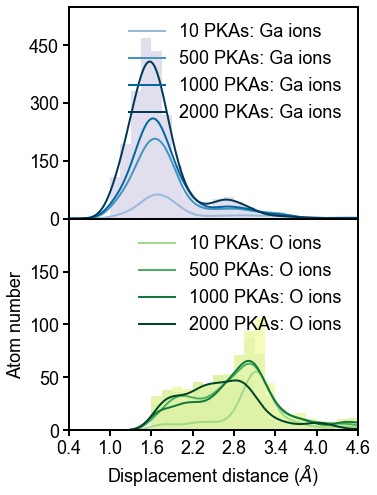

In [9]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs = plt.subplots(2, 1,figsize=(4.1,6),sharex=True)
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
bin_edges = np.linspace(1, 4,21)
print(bin_edges)
t = np.linspace(0.4, 4.6, 210) 
pkal=[10,500,1000,2000]
cmap = plt.get_cmap('PuBu')
n_ga_peak=np.zeros(4)
n_o_peak=np.zeros(4)
ga_peak=np.zeros(4)
o_peak=np.zeros(4)
print('----Ga-----')

for j in range(4):
    i=pkal[j]
    c= cmap((j+2)/5)
    fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(i)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 1)]
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)] 

    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[0].hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap((j+4)/40))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[0].plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
    n_ga_peak[j]=max(fit_y)
    index=np.argmax(fit_y)
    ga_peak[j]=t[index]
axs[0].tick_params(axis='x', width=0,length=2)
axs[0].set_yticks([ 0,150 ,300,450])
axs[0].legend(fontsize=18,frameon=False)
axs[0].tick_params(axis='y', width=2,length=6, labelsize=18)
axs[0].set_ylim(0, 550)
print('----O-----')
bin_edges = np.linspace(1.6, 4.6,21)
cmap2 = plt.get_cmap('YlGn')
for j in range(4):
    i=pkal[j]
    c2= cmap2((j+2)/5)
    fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(i)
    df=pd.read_csv(fn)
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)]     
    #d=dfGa['Displacement Magnitude']
    d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[1].hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap2((j+4)/30))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1)
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[1].plot(t,fit_y, label='{} PKAs: O ions'.format(i),linewidth=2,color=c2)
    n_o_peak[j]=max(fit_y)
    index=np.argmax(fit_y)
    o_peak[j]=t[index]
axs[1].set_xlabel('Displacement distance ($\AA$)',fontsize=18)
axs[1].set_ylabel('Atom number',fontsize=18)
axs[1].legend(fontsize=18,frameon=False)
axs[1].grid(False)
# Set the desired x-axis limits
axs[1].set_xticks([0.4,1.0,1.6,2.2,2.8,3.4,4,4.6])
axs[1].set_yticks([0,50,100,150])
axs[1].set_ylim(0, 200)
axs[1].set_xlim(0.4, 4.6)# Replace x_min and x_max with your desired range
axs[1].tick_params(axis='x', width=2,length=6,labelsize=18)
axs[1].tick_params(axis='y', width=2,length=6,labelsize=18)
plt.savefig('/home/heruhe/Desktop/overlapping1', format='svg')

----Ga-----
[ 4.87127746 14.40377784 17.24751825 26.70209544] [2.91196172 2.73110048 2.71100478 2.69090909]


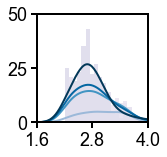

In [27]:
# Modify a global rcParam
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = (2,2) 
#find second peak of Ga ions
n_ga_peak2=np.zeros(4)
ga_peak2=np.zeros(4)
bin_edges = np.linspace(2.2, 4.0,21)
print('----Ga-----')

for j in range(4):
    i=pkal[j]
    c= cmap((j+2)/5)
    fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(i)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 2.2)]
    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    hist1, bin_edge, patches=plt.hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap((j+4)/40))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.2)*ex
    n_ga_peak2[j]=max(fit_y)
    index=np.argmax(fit_y)
    ga_peak2[j]=t[index]
    plt.plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
print(n_ga_peak2,ga_peak2)
plt.xticks([1.6,2.8,4])
plt.yticks([0,25,50])
plt.xlim(1.6, 4)
plt.tick_params(axis='x', width=2,length=6,labelsize=18)
plt.tick_params(axis='y', width=2,length=6,labelsize=18)
plt.savefig('/home/heruhe/Desktop/overlapping2', format='svg')

[ 62.58498096 207.49134647 260.31707035 408.03186626] [1.6861244  1.64593301 1.62583732 1.58564593]
[55.50435755 62.93086188 65.61991694 47.11329328] [3.13301435 3.03253589 3.01244019 2.81148325]
2.9973684210526312 1.6358851674641146 2.761244019138756


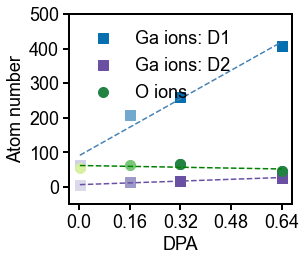

In [29]:
# Modify a global rcParam
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = (4,3.5) 

print(n_ga_peak,ga_peak)
print(n_o_peak,o_peak)
# Determine the number of colors you want
num_colors =4
cmap3 = plt.get_cmap('Purples')
# Create an array of colors using the colormap
colors = [cmap((i+1) / num_colors) for i in range(num_colors)]
colors2 = [cmap2((i+1) / num_colors) for i in range(num_colors)]
colors3 = [cmap3((i+1) / num_colors) for i in range(num_colors)]
for i in range(num_colors - 1):
    plt.plot(pkal[i:i+3], n_ga_peak[i:i+3],marker="s",linestyle='', color=colors[i],markersize=10)
    plt.plot(pkal[i:i+3], n_ga_peak2[i:i+3],marker="s",linestyle='', color=colors3[i],markersize=10)
    plt.plot(pkal[i:i+3], n_o_peak[i:i+3],marker="o",linestyle='', color=colors2[i],markersize=10)
       
plt.plot(pkal[i:i+3], n_ga_peak[i:i+3],marker="s",linestyle='', color=colors[i],markersize=10,label='Ga ions: D1')
plt.plot(pkal[i:i+3], n_ga_peak2[i:i+3],marker="s",linestyle='', color=colors3[i],markersize=10,label='Ga ions: D2')
plt.plot(pkal[i:i+3], n_o_peak[i:i+3],marker="o",linestyle='', color=colors2[i],markersize=10,label='O ions')   

#plt.plot(pkal,n_ga_peak,'s',markersize=10,color='steelblue',label='Ga1 ions')
x_fit,y_fit = linear_fit(pkal,n_ga_peak)
plt.plot(x_fit,y_fit,'--',color='steelblue')
#plt.plot(pkal,n_ga_peak2,'s',markersize=10,color='steelblue',label='Ga2 ions',markerfacecolor='white')
x_fit,y_fit = linear_fit(pkal,n_ga_peak2)
plt.plot(x_fit,y_fit,'--',color=colors3[i])
#plt.plot(pkal,n_o_peak,'o',markersize=10,color='green',label='O ions')
x_fit,y_fit = linear_fit(pkal,n_o_peak)
plt.plot(x_fit,y_fit,'--',color='green')
plt.xlim(-100, 2100)
plt.xticks([0,500,1000,1500,2000])
plt.yticks([0,100,200,300,400,500])
plt.ylim(-50, 500)
plt.tick_params(axis='x', width=2,length=6,labelsize=18)
plt.tick_params(axis='y', width=2,length=6,labelsize=18)
plt.xlabel('DPA',fontsize=18)
plt.ylabel('Atom number',fontsize=18)
plt.legend(fontsize=18,frameon=False)
# Changing x-axis ticks
plt.xticks([0,500,1000,1500,2000], [0.0, 0.16, 0.32, 0.48, 0.64])
plt.savefig('/home/heruhe/Desktop/overlapping3-2', format='svg')

print(np.mean(o_peak),np.mean(ga_peak),np.mean(ga_peak2))

(1.0, 500.0)

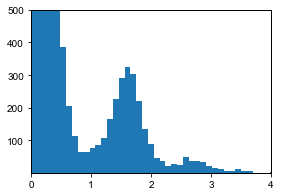

In [232]:
fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(1900)
df=pd.read_csv(fn)
dfGa = df[(df['Particle Type'] < 3)]
d=dfGa['Displacement Magnitude']

plt.hist(d, bins=50,histtype='bar')
plt.xlim(0, 4)
plt.ylim(1, 500)

,Unnamed: 0,Particle Type,Particle Identifier,Displacement Magnitude
1,1,3,60600,0.253467
2,2,4,71535,0.153347
3,3,4,59990,0.165823
5,5,3,60579,0.200420
7,7,4,27936,0.280972
...,...,...,...,...
81912,81912,5,49617,0.064192
81913,81913,3,39099,0.144880
81914,81914,5,49072,0.411189
81916,81916,3,59280,0.487490


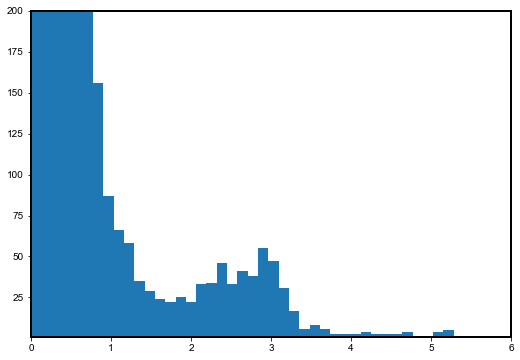

In [204]:
dfO = df[(df['Particle Type'] >2)]     
d=dfO['Displacement Magnitude']
plt.hist(d, bins=100,histtype='bar')
plt.xlim(0, 6)
plt.ylim(1, 200)
dfO

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

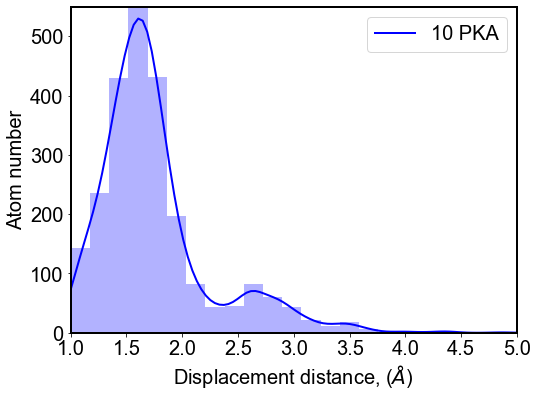

In [355]:
bin_edges = np.linspace(1, 6,30)
t = np.linspace(1, 5, 100) 
colors = ["blue","red",  "orange", "green", "orange", "yellow", "black"]
pkal=[10]
for j in range(1):
    i=pkal[j]
    c=colors[j]
    fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(1900)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 1)]
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)]     
    
    d=dfGa['Displacement Magnitude']
    #d=dfO['Displacement Magnitude']
   
    hist1, bin_edge, patches=plt.hist(d, bins=bin_edges,alpha=0.3,histtype='bar',color=c)
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]

    plt.plot(t, kernel_density(t, d, 0.1)*ex, label='{} PKA'.format(i),linewidth=2,color=c)
plt.xlabel('Displacement distance, ($\AA$)',fontsize=20)
plt.ylabel('Atom number',fontsize=20)
plt.legend(fontsize=20)
plt.rcParams["font.family"] = "arial"
plt.grid(False)
# Set the desired x-axis limits
plt.xlim(1, 5)
plt.ylim(0, 550)# Replace x_min and x_max with your desired range
plt.rcParams["axes.linewidth"] = 2 
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["figure.figsize"] = (8,6) 
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 

[1.   1.15 1.3  1.45 1.6  1.75 1.9  2.05 2.2  2.35 2.5  2.65 2.8  2.95
 3.1  3.25 3.4  3.55 3.7  3.85 4.  ]
----Ga-----
1.696254559929107 0.25817776501118267
19.0
1.7015091321895668 0.26322868726060933
39.0
1.7508176847887522 0.22890596359898355
41.0
1.707973126890315 0.26316896004158985
30.0
1.6852577581890271 0.21301898361795116
40.0
1.7181305194422876 0.22765291521171116
37.0
1.6858723024608597 0.2320756626705187
37.0
1.6909624802045247 0.2558399219112362
41.0
1.724215717496047 0.22178389001970264
43.0
----O-----
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


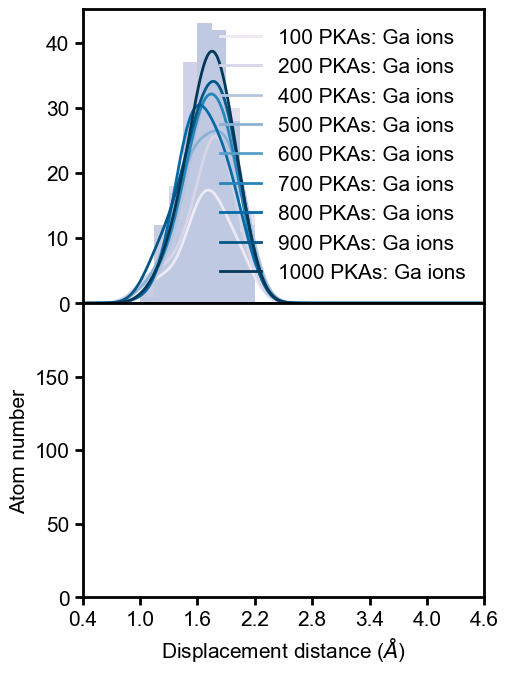

In [100]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs = plt.subplots(2, 1,figsize=(4.1,6),sharex=True)
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
bin_edges = np.linspace(1, 4,21)
print(bin_edges)
t = np.linspace(0.4, 4.6, 210) 

pkal=[100, 200, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
pkal=[ 100, 200, 400, 500, 600, 700, 800, 900, 1000 ]
cmap = plt.get_cmap('PuBu')
n_ga_peak=np.zeros(len(pkal))
n_o_peak=np.zeros(len(pkal))
ga_peak=np.zeros(len(pkal))
o_peak=np.zeros(len(pkal))
print('----Ga-----')

for j in range(len(pkal)):
    i=pkal[j]
    c= cmap((j+1)/len(pkal))
    fn='/Users/ruhe/Desktop/ga2o3/FP/tabGap/Ga/anneal_1000k_2ns/1000_2ns_{}/particle_Displacement_Magnitude.csv'.format(i)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 1)& (df['Displacement Magnitude'] < 2.2)]
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)] 

    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[0].hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap((j+4)/40))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[0].plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
    n_ga_peak[j]=max(hist1)
    print(n_ga_peak[j])
    index=np.argmax(fit_y)
    ga_peak[j]=t[index]
axs[0].tick_params(axis='x', width=0,length=2)
#axs[0].set_yticks([ 0,150 ,300,450])
axs[0].legend(fontsize=15,frameon=False)
axs[0].tick_params(axis='y', width=2,length=6, labelsize=15)
#axs[0].set_ylim(0, 550)
print('----O-----')
bin_edges = np.linspace(1.6, 4.6,21)
cmap2 = plt.get_cmap('YlGn')
for j in range(len(pkal)):
    i=pkal[j]
    c2= cmap2((j+1)/len(pkal))
    fn='/Users/ruhe/Desktop/ga2o3/FP/tabGap/Ga/anneal_1000k_2ns/1000_2ns_{}/particle_Displacement_Magnitude.csv'.format(i)
    df=pd.read_csv(fn)
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)]     
    #d=dfGa['Displacement Magnitude']
    d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[1].hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap2((j+4)/30))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1)
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[1].plot(t,fit_y, label='{} PKAs: O ions'.format(i),linewidth=2,color=c2)
    n_o_peak[j]=max(fit_y)
    index=np.argmax(fit_y)
    o_peak[j]=t[index]
axs[1].set_xlabel('Displacement distance ($\AA$)',fontsize=15)
axs[1].set_ylabel('Atom number',fontsize=15)
#axs[1].legend(fontsize=15,frameon=False)
axs[1].grid(False)
# Set the desired x-axis limits
axs[1].set_xticks([0.4,1.0,1.6,2.2,2.8,3.4,4,4.6])
axs[1].set_yticks([0,50,100,150])
axs[1].set_ylim(0, 200)
axs[1].set_xlim(0.4, 4.6)# Replace x_min and x_max with your desired range
axs[1].tick_params(axis='x', width=2,length=6,labelsize=15)
axs[1].tick_params(axis='y', width=2,length=6,labelsize=15)
#plt.savefig('my_plot.png')

----Ga-----
[ 8.  9.  9. 11.  9.  9.  9. 10. 11.] [3.2937799  3.13301435 2.89186603 2.79138756 2.87177033 2.87177033
 2.73110048 0.4        2.85167464]


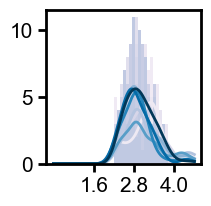

In [103]:
# Modify a global rcParam
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = (2,2) 
#find second peak of Ga ions
n_ga_peak2=np.zeros(len(pkal))
ga_peak2=np.zeros(len(pkal))
bin_edges = np.linspace(2.2, 4.0,21)
print('----Ga-----')

for j in range(len(pkal)):
    i=pkal[j]
    c= cmap((j+1)/len(pkal))
    fn='/Users/ruhe/Desktop/ga2o3/FP/tabGap/Ga/anneal_1000k_2ns/1000_2ns_{}/particle_Displacement_Magnitude.csv'.format(i)    
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 2.2)]
    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    hist1, bin_edge, patches=plt.hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap((j+4)/40))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.2)*ex
    n_ga_peak2[j]=max(hist1)
    index=np.argmax(fit_y)
    ga_peak2[j]=t[index]
    plt.plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
print(n_ga_peak2,ga_peak2)
plt.xticks([1.6,2.8,4])
#plt.yticks([0,25,50])
#plt.xlim(1.6, 4)
plt.tick_params(axis='x', width=2,length=6,labelsize=15)
plt.tick_params(axis='y', width=2,length=6,labelsize=15)

[100, 200, 400, 500, 600, 700, 800, 900, 1000]
[19. 39. 41. 30. 40. 37. 37. 41. 43.]


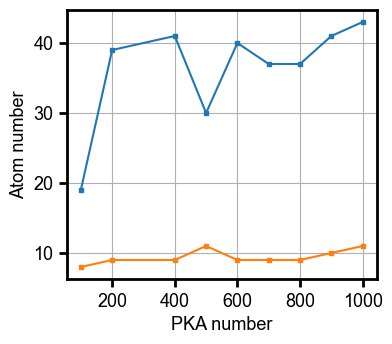

In [61]:
# Modify a global rcParam
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = (4,3.5) 



plt.plot(pkal, n_ga_peak,marker="s",linestyle='-',markersize=3)
plt.plot(pkal, n_ga_peak2,marker="s",linestyle='-',markersize=3)
print(pkal)
print(n_ga_peak)
plt.tick_params(axis='x', width=2,length=6,labelsize=13)
plt.tick_params(axis='y', width=2,length=6,labelsize=13)
plt.xlabel('PKA number',fontsize=13)
plt.ylabel('Atom number',fontsize=13)
plt.grid()


[1.   1.15 1.3  1.45 1.6  1.75 1.9  2.05 2.2  2.35 2.5  2.65 2.8  2.95
 3.1  3.25 3.4  3.55 3.7  3.85 4.  ]
----Ga-----
2.3386153341632103 0.6185730484239084
18.0
2.3736360492241273 0.7642524781467593
19.0
2.5422582089028625 0.8241758427536863
24.0


([<matplotlib.axis.XTick at 0x13f379810>,
 [Text(1.6, 0, '1.6'), Text(2.8, 0, '2.8'), Text(4.0, 0, '4.0')])

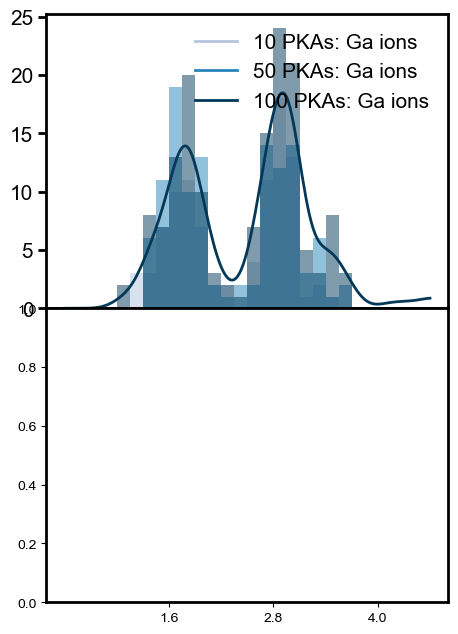

In [7]:
#FPA GAMMA 
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs = plt.subplots(2, 1,figsize=(4.1,6),sharex=True)
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
bin_edges = np.linspace(1, 4,21)
print(bin_edges)
t = np.linspace(0.4, 4.6, 210) 

pkal=[ 10,50,100]
cmap = plt.get_cmap('PuBu')
n_ga_peak=np.zeros(len(pkal))
n_o_peak=np.zeros(len(pkal))
ga_peak=np.zeros(len(pkal))
o_peak=np.zeros(len(pkal))
print('----Ga-----')

for j in range(len(pkal)):
    i=pkal[j]
    c= cmap((j+1)/len(pkal))
    fn='/Users/ruhe/Desktop/ga2o3/FP/tabGap/gamma/anneal1000k_2ns/1000_2ns_{}/particle_Displacement_Magnitude.csv'.format(i)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 1)]
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)] 

    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[0].hist(d, bins=bin_edges,alpha=0.5,histtype='bar',color=c)
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[0].plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
    n_ga_peak[j]=max(hist1)
    print(n_ga_peak[j])
    index=np.argmax(fit_y)
    ga_peak[j]=t[index]
axs[0].tick_params(axis='x', width=0,length=2)
#axs[0].set_yticks([ 0,150 ,300,450])
axs[0].legend(fontsize=15,frameon=False)
axs[0].tick_params(axis='y', width=2,length=6, labelsize=15)
plt.xticks([1.6,2.8,4])

[1.   1.15 1.3  1.45 1.6  1.75 1.9  2.05 2.2  2.35 2.5  2.65 2.8  2.95
 3.1  3.25 3.4  3.55 3.7  3.85 4.  ]
----Ga-----


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ruhe/Desktop/ga2o3/overlapping/overlapping_anneal/gamma/2kev_1000k_100ps/1000_100ps_10/particle_Displacement_Magnitude.csv'

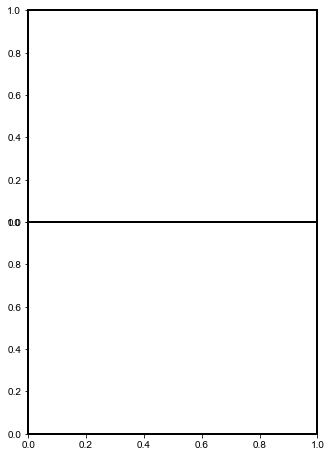

In [15]:
#cascade_anneal GAMMA 
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs = plt.subplots(2, 1,figsize=(4.1,6),sharex=True)
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
bin_edges = np.linspace(1, 4,21)
print(bin_edges)
t = np.linspace(0.4, 4.6, 210) 

pkal=[10,30,50]
cmap = plt.get_cmap('PuBu')
n_ga_peak=np.zeros(len(pkal))
n_o_peak=np.zeros(len(pkal))
ga_peak=np.zeros(len(pkal))
o_peak=np.zeros(len(pkal))
print('----Ga-----')

for j in range(len(pkal)):
    i=pkal[j]
    c= cmap((j+1)/len(pkal))
    fn='/Users/ruhe/Desktop/ga2o3/overlapping/overlapping_anneal/gamma/2kev_1000k_100ps/1000_100ps_{}/particle_Displacement_Magnitude.csv'.format(i)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 2) & (df['Displacement Magnitude'] > 1)]
    dfO = df[(df['Particle Type'] >1) & (df['Displacement Magnitude'] > 1.6)] 

    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[0].hist(d, bins=bin_edges,alpha=0.5,histtype='bar',color=c)
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[0].plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
    n_ga_peak[j]=max(hist1)
    #print(n_ga_peak[j])
    index=np.argmax(fit_y)
    ga_peak[j]=t[index]
axs[0].tick_params(axis='x', width=0,length=2)
#axs[0].set_yticks([ 0,150 ,300,450])
axs[0].legend(fontsize=15,frameon=False)
axs[0].tick_params(axis='y', width=2,length=6, labelsize=15)
print('----O-----')
bin_edges = np.linspace(1.6, 8.6,21)
cmap2 = plt.get_cmap('YlGn')
for j in range(len(pkal)):
    i=pkal[j]
    c2= cmap2((j+2)/5)
    fn='/Users/ruhe/Desktop/ga2o3/overlapping/overlapping_anneal/gamma/2kev_1000k_100ps/1000_100ps_{}/particle_Displacement_Magnitude.csv'.format(i)    
    df=pd.read_csv(fn)
    dfO = df[(df['Particle Type'] >1) & (df['Displacement Magnitude'] > 1.6)]     
    #d=dfGa['Displacement Magnitude']
    d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[1].hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap2((j+4)/30))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1)
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[1].plot(t,fit_y, label='{} PKAs: O ions'.format(i),linewidth=2,color=c2)
    n_o_peak[j]=max(fit_y)

    index=np.argmax(fit_y)
    o_peak[j]=t[index]
axs[1].set_xlabel('Displacement distance ($\AA$)',fontsize=15)
axs[1].set_ylabel('Atom number',fontsize=15)
axs[1].legend(fontsize=15,frameon=False)
axs[1].grid(False)
# Set the desired x-axis limits
axs[1].set_xticks([0.4,1.0,1.6,2.2,2.8,3.4,4,4.6])
axs[1].set_yticks([0,50,100,150])
axs[1].set_ylim(0, 200)
axs[1].set_xlim(0.4, 8.6)# Replace x_min and x_max with your desired range
axs[1].tick_params(axis='x', width=2,length=6,labelsize=15)
axs[1].tick_params(axis='y', width=2,length=6,labelsize=15)

    
plt.xticks([1.6,2.2,2.8,3.4,4])

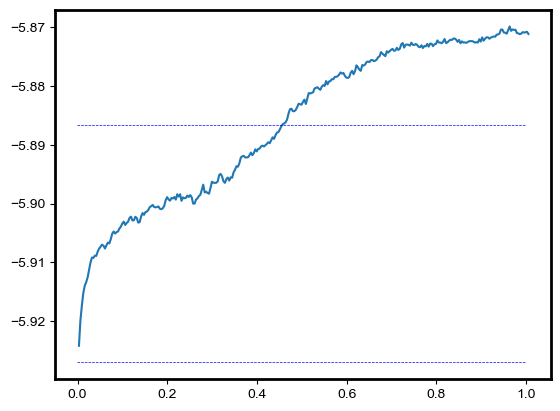

In [40]:
path='/Users/ruhe/Desktop/ga2o3/overlapping/overlapping_anneal/1000K_100ps/log_files/anneal_log'

os.chdir(path) 
pka=[i for i in range(10,3130,10) ]
# Create a new list without '2980', as disc limit the 2980 anneal cannot finish
pka = [i for i in pka if i != 2980]
pe=[]
for i in pka:
    fout=str(i)+'.log'

    log= pd.read_csv(fout, sep=' ',header=None)
    log.columns=['step', 'dt', 'press', 'pxx', 'pyy', 'pzz', 'lx', 'ly', 'lz', 'temp', 'v_avol', 'v_ake', 'v_ape']
    pe_stable=list(log['v_ape'])[-1]
    pe.append(list(log['v_ape'])[-1])
    #if pe_stable>-5.86:
        #print(i,pe_stable)

PE=pd.DataFrame()
PE['PKA']=pka
PE['pe']=np.array(pe)
dpa=np.zeros(len(PE['PKA']))
for i in range(len(PE['PKA'])):
    dpa[i]=DPA(1500,PE['PKA'][i],193.294,81920,TDEga2o3)
PE['DPA']=dpa
PE.to_csv('pe')
PE.drop(PE.index[85], inplace=True)



plt.plot(PE['DPA'],PE['pe'])
beta=[-485546.0543 /81920 for i in range(2400)]
gamma=[-1220670.514 /207360 for i in range(2400)]
#gamma=[-5.88761304 for i in range(2400) ]

 
plt.plot([i/2400 for i in range(2400)],gamma,'--',linewidth=0.5,color='blue')
plt.plot([i/2400 for i in range(2400)],beta,'--',linewidth=0.5,color='blue')

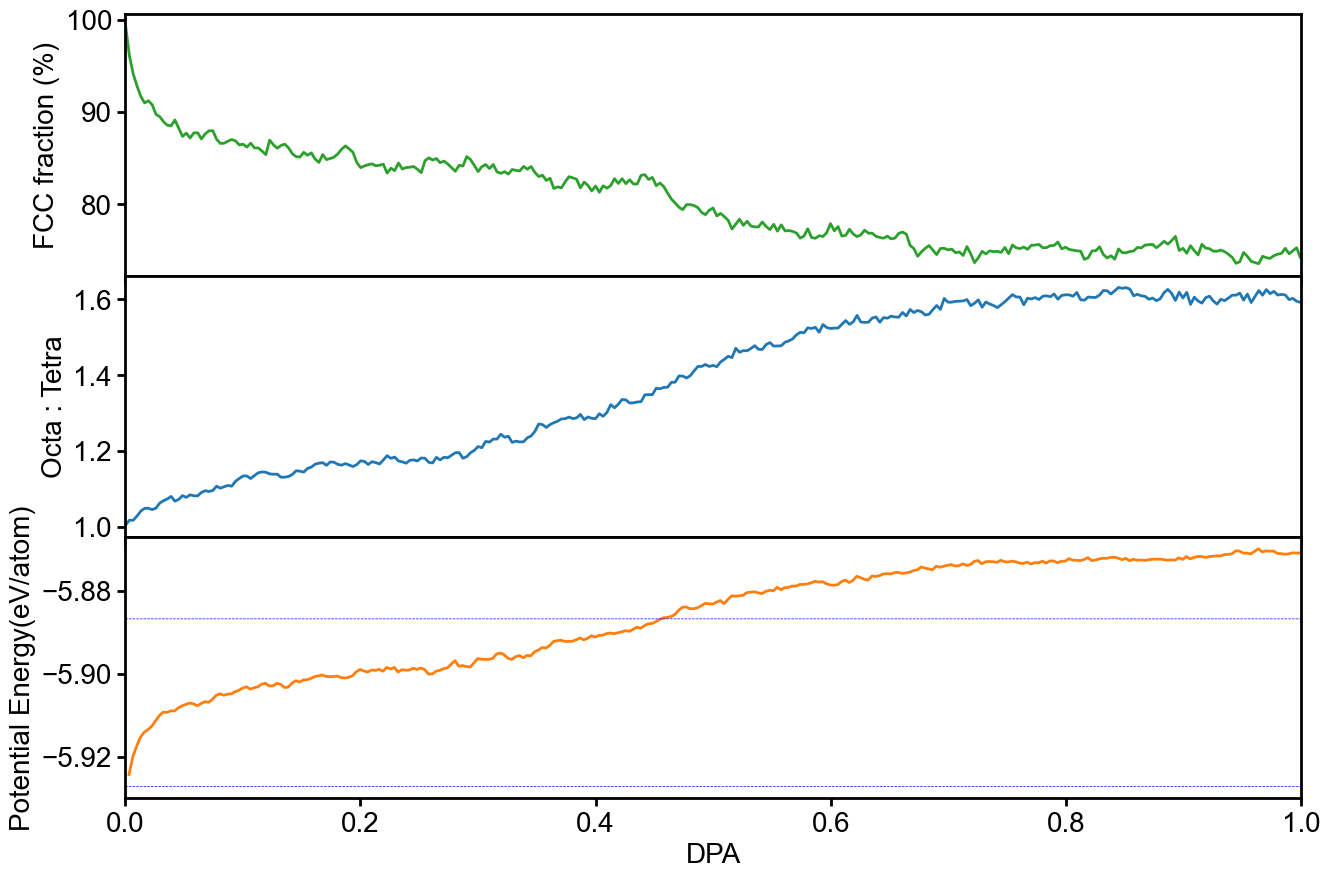

In [57]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs =plt.subplots(3, 1,figsize=(12,8),sharex=True)
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
path='/Users/ruhe/Desktop/ga2o3/overlapping/overlapping_anneal/1000K_100ps/oct_tetra'
os.chdir(path) 
df=pd.read_csv('t_o_fcc1',sep=' ')
df = df.drop(df.columns[-1], axis=1)

df.columns=['tetra','oct','fcc']
df['o_t']=df['oct']/df['tetra']
df['fcc']=df['fcc']/81920/0.6*100
df['PKA']=np.array([i+1 for i in range(0,3160,10) ])
dpa=np.zeros(len(df['PKA']))
for i in range(len(df['PKA'])):
    dpa[i]=DPA(1500,df['PKA'][i],193.294,81920,TDEga2o3)
df['DPA']=dpa
df.drop(df.index[86], inplace=True)
df.drop(df.index[297], inplace=True)#simulation didnot finish

#plt.plot(df['DPA'],df['o_t'])
axs[0].plot(df['DPA'],df['fcc'],linewidth=2,color='C2')
axs[1].plot(df['DPA'],df['o_t'],linewidth=2,color='C0')
axs[2].plot(PE['DPA'],PE['pe'],linewidth=2,color='C1')
 
axs[2].plot([i/2400 for i in range(2400)],gamma,'--',linewidth=0.5,color='blue')
axs[2].plot([i/2400 for i in range(2400)],beta,'--',linewidth=0.5,color='blue')
axs[2].set_xlabel('DPA',fontsize=20)
axs[1].set_ylabel('Octa : Tetra',fontsize=20)
axs[0].set_ylabel('FCC fraction (%)',fontsize=20)
axs[2].set_ylabel('Potential Energy(eV/atom)',fontsize=20)
axs[1].grid(False)
# Set the desired x-axis limits
axs[1].set_xlim(0, 1.0)# Replace x_min and x_max with your desired range
axs[0].tick_params( width=2,length=6,labelsize=20)
axs[1].tick_params( width=2,length=6,labelsize=20)
axs[2].tick_params( width=2,length=6,labelsize=20)
#plt.savefig('/Users/ruhe/Desktop/overlapping3-3', format='svg')


In [ ]:
 ä

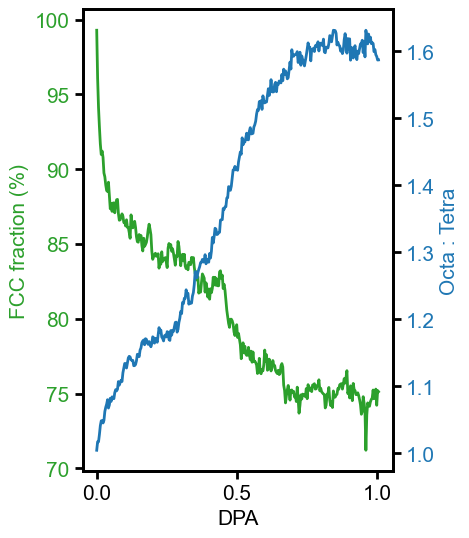

In [24]:

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, ax1 = plt.subplots(figsize=(4,6))
ax1.spines['right'].set_position(('axes', 1.0))
ax1.plot(df['DPA'],df['fcc'],linewidth=2,color='C2')
ax1.set_ylabel('FCC fraction (%)',fontsize=15,color='C2')
ax1.tick_params(axis='y', labelcolor='C2')
ax1.set_xlabel('DPA',fontsize=15)
ax2 = ax1.twinx()
ax2.plot(df['DPA'],df['o_t'],linewidth=2,color='C0')
ax2.set_ylabel('Octa : Tetra',fontsize=15,color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
ax1.tick_params( width=2,length=6,labelsize=15)
ax2.tick_params( width=2,length=6,labelsize=15)
plt.savefig('/Users/ruhe/Desktop/overlapping3-3', format='svg')

854


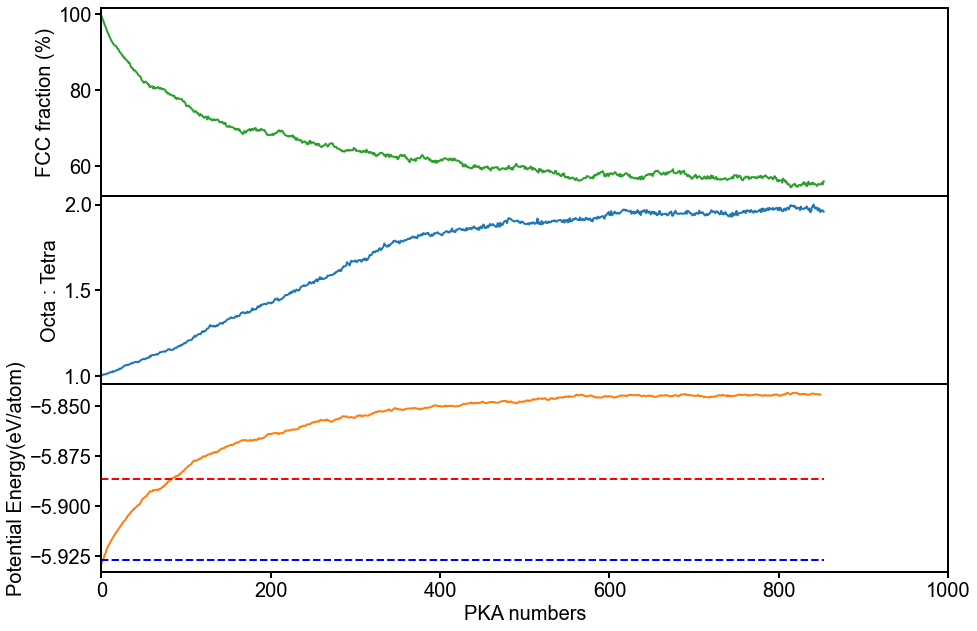

In [22]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs =plt.subplots(3, 1,figsize=(12,8),sharex=True)

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
path='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_npt/small1500ev_npt_1/oct_tetra/'
fn=path+'t_o_fcc_0'
df=pd.read_csv(fn,sep=' ')
df = df.drop(df.columns[-1], axis=1)

df.columns=['tetra','oct','fcc']

df['o_t']=df['oct']/df['tetra']
df['fcc']=df['fcc']/81920/0.6*100

#plt.plot(df['DPA'],df['o_t'])
axs[0].plot(df['fcc'],linewidth=2,color='C2')
axs[1].plot(df['o_t'],linewidth=2,color='C0')

path2='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_npt/small1500ev_npt_1/npt_log/'
pe=[]
print(len(df['o_t']))
for i in range(1,len(df['o_t'])-3):
    fn2=path2+'lammps-npt_2ps{}.log'.format(i)
    log = lammps_logfile.File(fn2)
    pe.append(log.get("v_ape")[-1])


axs[2].plot(pe,linewidth=2,color='C1')

beta=[-485546.0543 /81920 for i in range(len(df['o_t']))]

gamma=[-1220670.514 /207360 for i in range(len(df['o_t']))] 
axs[2].plot(gamma,'--',linewidth=2,color='red')
axs[2].plot(beta,'--',linewidth=2,color='blue')
axs[2].set_xlabel('PKA numbers',fontsize=20)
axs[1].set_ylabel('Octa : Tetra',fontsize=20)
axs[0].set_ylabel('FCC fraction (%)',fontsize=20)
axs[2].set_ylabel('Potential Energy(eV/atom)',fontsize=20)
axs[1].grid(False)
# Set the desired x-axis limits
axs[2].set_xlim([0,1000])
axs[0].tick_params( width=2,length=6,labelsize=20)
axs[1].tick_params( width=2,length=6,labelsize=20)
axs[2].tick_params( width=2,length=6,labelsize=20)
#plt.savefig('/Users/ruhe/Desktop/overlapping3-3', format='svg')

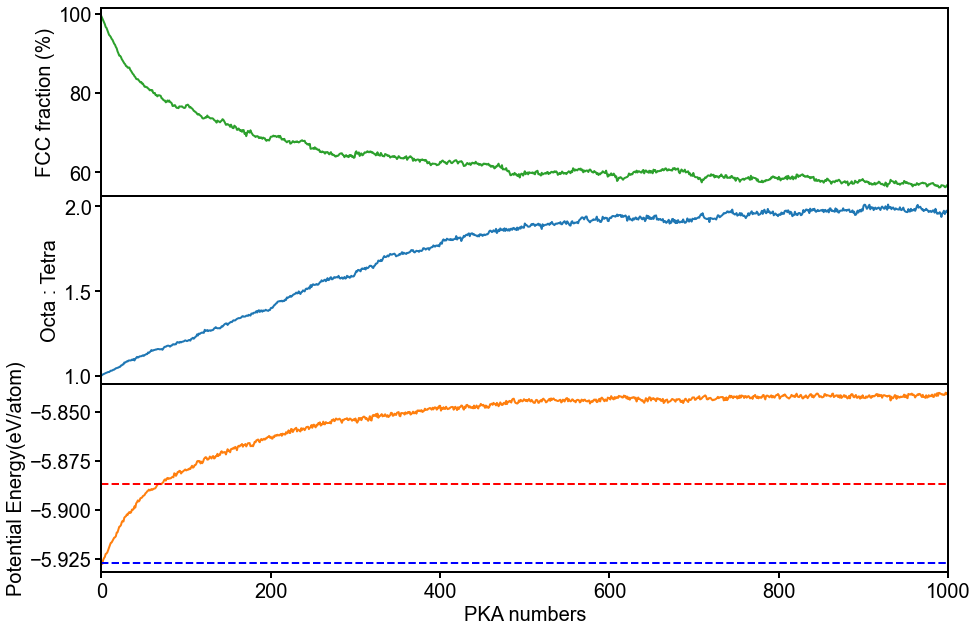

In [21]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs =plt.subplots(3, 1,figsize=(12,8),sharex=True)

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
path='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_npt/small1500ev_npt_100/oct_tetra/'
fn=path+'t_o_fcc'
df=pd.read_csv(fn,sep=' ')
df = df.drop(df.columns[-1], axis=1)

df.columns=['tetra','oct','fcc']

df['o_t']=df['oct']/df['tetra']
df['fcc']=df['fcc']/81920/0.6*100

#plt.plot(df['DPA'],df['o_t'])
axs[0].plot(df['fcc'],linewidth=2,color='C2')
axs[1].plot(df['o_t'],linewidth=2,color='C0')

path2='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_npt/small1500ev_npt_100/log/'
pe=[]
pka=[i for i in range(1,1001)]
#print(pka)
for i in pka:
    fn2=path2+'{}.dat'.format(i)
    log =pd.read_csv(fn2, sep=' ',header=None)
    log.columns=['step','t','T','pe','ke','etotal','Press','v']
    pe.append(list(log['pe'])[-1]/81920)

axs[2].plot(pka,pe,linewidth=2,color='C1')

beta=[-485546.0543 /81920 for i in range(len(df['o_t']))]

gamma=[-1220670.514 /207360 for i in range(len(df['o_t']))] 
axs[2].plot(gamma,'--',linewidth=2,color='red')
axs[2].plot(beta,'--',linewidth=2,color='blue')
axs[2].set_xlabel('PKA numbers',fontsize=20)
axs[2].set_xlim([0,1000])
axs[1].set_ylabel('Octa : Tetra',fontsize=20)
axs[0].set_ylabel('FCC fraction (%)',fontsize=20)
axs[2].set_ylabel('Potential Energy(eV/atom)',fontsize=20)
axs[1].grid(False)
# Set the desired x-axis limits

axs[0].tick_params( width=2,length=6,labelsize=20)
axs[1].tick_params( width=2,length=6,labelsize=20)
axs[2].tick_params( width=2,length=6,labelsize=20)
#plt.savefig('/Users/ruhe/Desktop/overlapping3-3', format='svg')

803


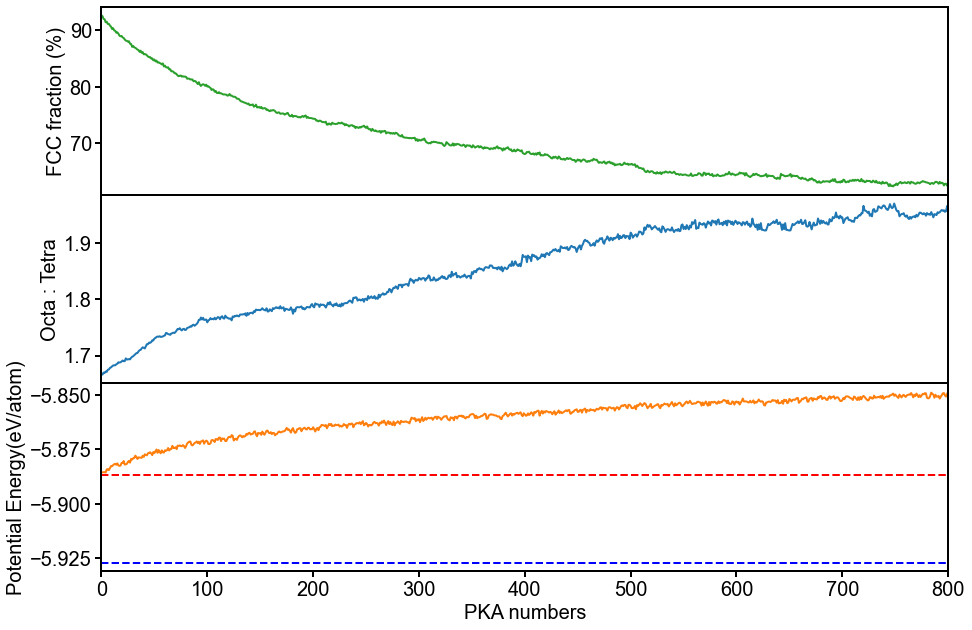

In [14]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs =plt.subplots(3, 1,figsize=(12,8),sharex=True)

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
path='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_npt/gamma2000ev_npt_100/oct_tetra/'
fn=path+'t_o_fcc'
df=pd.read_csv(fn,sep=' ')
df = df.drop(df.columns[-1], axis=1)

df.columns=['oct','tetra','fcc']

df['o_t']=df['oct']/df['tetra']
df['fcc']=df['fcc']/207360/0.6*100
print(len(df['o_t']))
#plt.plot(df['DPA'],df['o_t'])
axs[0].plot(df['fcc'],linewidth=2,color='C2')
axs[1].plot(df['o_t'],linewidth=2,color='C0')

path2='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_npt/gamma2000ev_npt_100/log/log/'
pe=[]
pka=[i for i in range(1,801)]
#print(pka)
for i in pka:
    fn2=path2+'{}.dat'.format(i)
    log =pd.read_csv(fn2, sep=' ',header=None)
    log.columns=['step','t','T','pe','ke','etotal','Press','v']
    pe.append(list(log['pe'])[-1]/207360)

axs[2].plot(pka,pe,linewidth=2,color='C1')

beta=[-485546.0543 /81920 for i in range(len(df['o_t']))]

gamma=[-1220670.514 /207360 for i in range(len(df['o_t']))] 
axs[2].plot(gamma,'--',linewidth=2,color='red')
axs[2].plot(beta,'--',linewidth=2,color='blue')
axs[2].set_xlabel('PKA numbers',fontsize=20)
axs[2].set_xlim([0,1000])
axs[1].set_ylabel('Octa : Tetra',fontsize=20)
axs[0].set_ylabel('FCC fraction (%)',fontsize=20)
axs[2].set_ylabel('Potential Energy(eV/atom)',fontsize=20)
axs[1].grid(False)
# Set the desired x-axis limits
axs[2].set_xlim([0,800])
axs[0].tick_params( width=2,length=6,labelsize=20)
axs[1].tick_params( width=2,length=6,labelsize=20)
axs[2].tick_params( width=2,length=6,labelsize=20)
#plt.savefig('/Users/ruhe/Desktop/overlapping3-3', format='svg')

In [16]:

def anisotropic_swelling(lx0, ly0, lz0, avol0, pka, path):
    """
    Plots the size deformation before and after NPT annealing.

    Parameters:
    lx0, ly0, lz0 : float
        Original simulation box size in x, y, z directions respectively.
    avol0 : float
        Original atomic volume.
    pka : list
        List of PKA numbers.
    path : str
        File path to the directory containing the LAMMPS log files.

    Returns:
    None
    """

    # Set up the plot parameters
    plt.rcParams['axes.linewidth'] = 1
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams["font.family"] = "arial"
    fig, axs = plt.subplots(1, figsize=(6/2.54, 4.6/2.54), sharey=True)
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.05, hspace=0.1)

    # Initialize lists to hold deformation data
    avol, lx, ly, lz = [], [], [], []
    lx1, ly1, lz1 = [], [], []

    # Read data from LAMMPS log files
    for i in pka:
        fn = f'{path}lammps-npt_2ps{i}.log'
        log = lammps_logfile.File(fn)
        avol.append(log.get("v_avol")[-1] / avol0)
        lx.append((log.get("Lx")[-1] / lx0)*100-100)
        ly.append((log.get("Ly")[-1] / ly0)*100-100)
        lz.append((log.get("Lz")[-1] / lz0)*100-100)
        lx1.append((log.get("Lx")[0] / lx0)*100-100)
        ly1.append((log.get("Ly")[0] / ly0)*100-100)
        lz1.append((log.get("Lz")[0] / lz0)*100-100)
    #print(log.get("Lx")[0],log.get("Ly")[0],log.get("Lz")[0])
    # Plot the data
    axs.plot(pka, lx, marker="o", color='royalblue', linestyle='--', markersize=5, label='x')
    axs.plot(pka, ly, marker="o", color='green', linestyle='--', markersize=5, label='y')
    axs.plot(pka, lz, marker="o", color='orangered', linestyle='--', markersize=5, label='z')
    axs.plot(pka, lx1, color='royalblue', marker="o", markerfacecolor='white', linestyle='', markersize=5)
    axs.plot(pka, ly1, color='green', marker="o", markerfacecolor='white', linestyle='', markersize=5)
    axs.plot(pka, lz1, color='orangered', marker="o", markerfacecolor='white', linestyle='', markersize=5)

    # Add arrows to indicate deformation direction
    #for i in range(len(pka)):
        #axs.annotate('', xy=(pka[i], lz[i]), xytext=(pka[i], lz1[i]), arrowprops=dict(color='red', arrowstyle='->', lw=1, ls='-'))

    # Set labels and legend
    axs.set_ylabel('Deformation Fraction (%)', fontsize=10)
    axs.set_xlabel('PKA numbers', fontsize=10)
    axs.tick_params(width=1, length=3, labelsize=10)
    axs.legend(fontsize=10, frameon=False)
    # Set y-axis limits
    axs.set_ylim([-4, 4])  # Assuming deformation fraction ranges from -0.2% to 0.2%
    # Display the plot
    plt.grid()
    plt.show()
    #plt.plot(pka,avol)
    return lx,ly,lz,avol
# Example usage:
#anisotropic_swelling(lx0, ly0, lz0, avol0, pka, path)


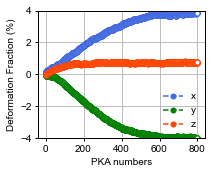

0.013962512327035484 -0.0123464619812178 0.006897590541500023


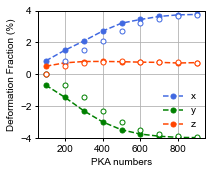

3.4402141352751983 -3.7353397051398503 0.7675927036852528


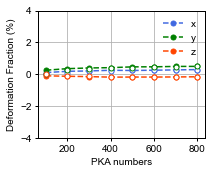

In [32]:

avol0=11.0838
lx0=97.1442   
ly0=99.03  
lz0=94.349
pka=[i for i in range(1,800)]
path2='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_npt/small1500ev_npt_1/npt_log/'
lx,ly,lz,avol=anisotropic_swelling(lx0, ly0, lz0, avol0, pka, path2)
print(lx[155]/100,ly[155]/100,lz[155]/100)
pka=[i for i in range(100,1000,100)]
path2='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_npt/small1500ev_npt_100/npt_log/'
lx,ly,lz,avol=anisotropic_swelling(lx0, ly0, lz0, avol0, pka, path2)
print(lx[5],ly[5],lz[5])
avol0=11.03859705
lx0=142.1211565 
ly0=122.808571
lz0=131.1449144
pka=[i for i in range(100,801,100)]
path2='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_npt/gamma2000ev_npt_100/npt_log/'
lx,ly,lz,avol=anisotropic_swelling(lx0, ly0, lz0, avol0, pka, path2)


-0.9524129804151563

27
-5.819542026250001


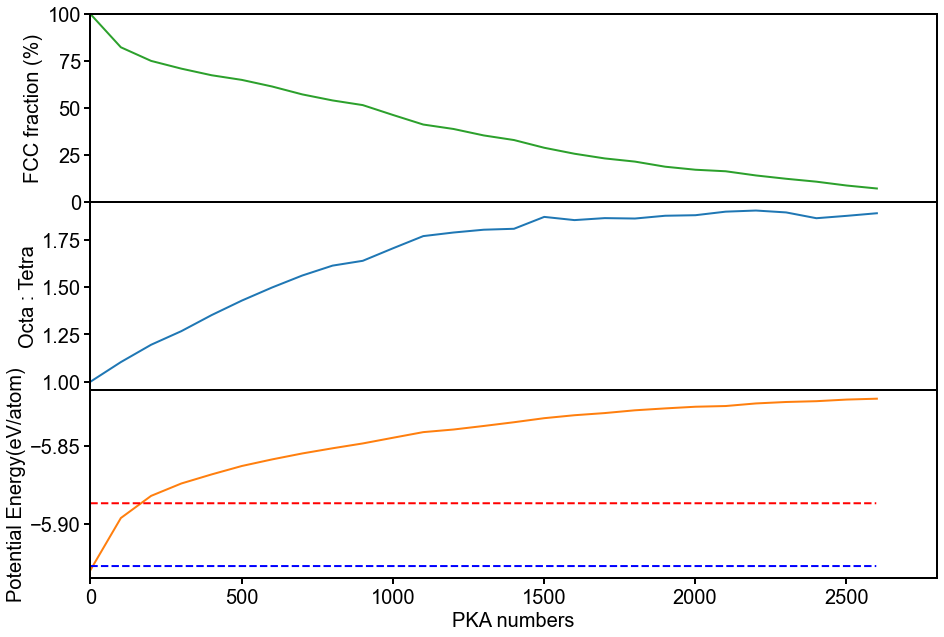

In [4]:
#big box overlap nvt

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs =plt.subplots(3, 1,figsize=(12,8),sharex=True)

pka = [i for i in range(1, 2650, 100)]
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
path='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade/bigbox/'
fn=path+'fcc'
df=pd.read_csv(fn,sep=' ')
df = df.drop(df.columns[-1], axis=1)

df.columns=['tetra','oct','fcc']
axs[0].set_ylim([0,100])
df['o_t']=df['oct']/df['tetra']
df['fcc']=df['fcc']/160000/0.6*100
print(len(df['o_t']))
#plt.plot(df['DPA'],df['o_t'])
axs[0].plot(pka,df['fcc'],linewidth=2,color='C2')
axs[1].plot(pka,df['o_t'],linewidth=2,color='C0')

path2='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade/bigbox/log/'
pe=[]
pka=[i for i in range(1,2650,100)]
#print(pka)
for i in pka:
    fn2=path2+'{}.dat'.format(i)
    log =pd.read_csv(fn2, sep=' ',header=None)
    log.columns=['step','t','T','pe','ke','etotal','Press','v']
    pe.append(list(log['pe'])[-1]/160000)
  
axs[2].plot(pka,pe,linewidth=2,color='C1')
print(pe[-1])
beta=[-485546.0543 /81920 for i in range(2600)]

gamma=[-1220670.514 /207360 for i in range(2600)] 
axs[2].plot(gamma,'--',linewidth=2,color='red')
axs[2].plot(beta,'--',linewidth=2,color='blue')
axs[2].set_xlabel('PKA numbers',fontsize=20)
axs[2].set_xlim([0,2800])
axs[1].set_ylabel('Octa : Tetra',fontsize=20)
axs[0].set_ylabel('FCC fraction (%)',fontsize=20)
axs[2].set_ylabel('Potential Energy(eV/atom)',fontsize=20)
axs[1].grid(False)
# Set the desired x-axis limits
axs[2].set_xlim([0,2800])
axs[0].tick_params( width=2,length=6,labelsize=20)
axs[1].tick_params( width=2,length=6,labelsize=20)
axs[2].tick_params( width=2,length=6,labelsize=20)
#plt.savefig('/Users/ruhe/Desktop/overlapping3-3', format='svg')

-5.8450900612500005


(0.0, 1000.0)

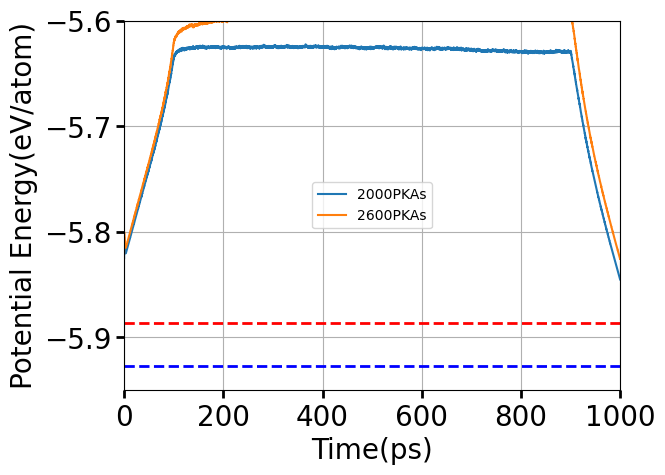

In [28]:
import lammps_logfile

fn='/Users/ruhe/Desktop/ga2o3/overlapping/bigbox_without_npt/lammps-anneal2000.log'
log = lammps_logfile.File(fn)
print((log.get("PotEng")/160000)[-1])
plt.plot(log.get('Time'),log.get("PotEng")/160000,label='2000PKAs')
fn='/Users/ruhe/Desktop/ga2o3/overlapping/bigbox_without_npt/lammps-anneal2600.log'
log = lammps_logfile.File(fn)
plt.plot(log.get('Time'),log.get("PotEng")/160000,label='2600PKAs')
plt.legend()
plt.xlim([0,1400])
plt.ylim([-5.95,-5.6])
plt.grid()
plt.xlabel('Time(ps)',fontsize=20)
plt.ylabel('Potential Energy(eV/atom)',fontsize=20)
plt.tick_params( width=2,length=6,labelsize=20)
beta=[-485546.0543 /81920 for i in range(1000)]

gamma=[-1220670.514 /207360 for i in range(1000)] 
plt.plot(beta,'--',linewidth=2,color='blue')
plt.plot(gamma,'--',linewidth=2,color='red')
plt.xlim([0,1000])

1000
-5.889463746250001
1200
-5.879017708125001
1400
-5.87433101375
1600
-5.868628338125
1800
-5.863925005625
2000
-5.8600303375000005
2200
-5.857965748124999
2400
-5.8544631575


(0.0, 900.0)

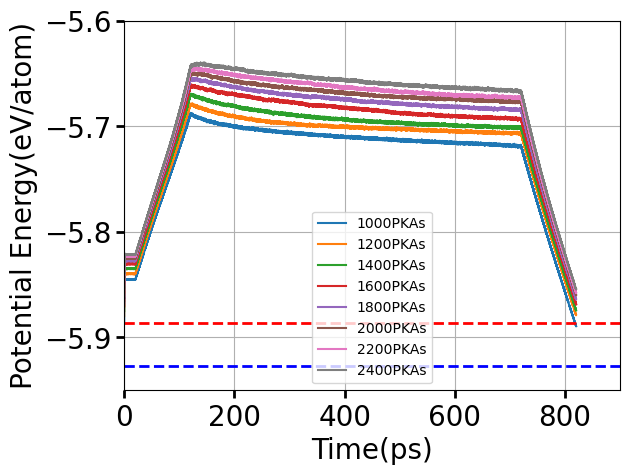

In [29]:
import re


numbers = [1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400]
for n in numbers:
    fn='/Users/ruhe/Desktop/ga2o3/overlapping/bigbox_without_npt/nvt_log/log/lammps-anneal{}.log'.format(n)
    print(n)
    log = lammps_logfile.File(fn)
    plt.plot(log.get('Time'),log.get("PotEng")/160000,label='{}PKAs'.format(n))
    print((log.get("PotEng")/160000)[-1])
    plt.legend()
plt.ylim([-5.95,-5.6])
plt.grid()
plt.xlabel('Time(ps)',fontsize=20)
plt.ylabel('Potential Energy(eV/atom)',fontsize=20)
plt.tick_params( width=2,length=6,labelsize=20)
beta=[-485546.0543 /81920 for i in range(900)]

gamma=[-1220670.514 /207360 for i in range(900)] 
plt.plot(beta,'--',linewidth=2,color='blue')
plt.plot(gamma,'--',linewidth=2,color='red')
plt.xlim([0,900])

57
-5.824030323486328 15.370686848958334


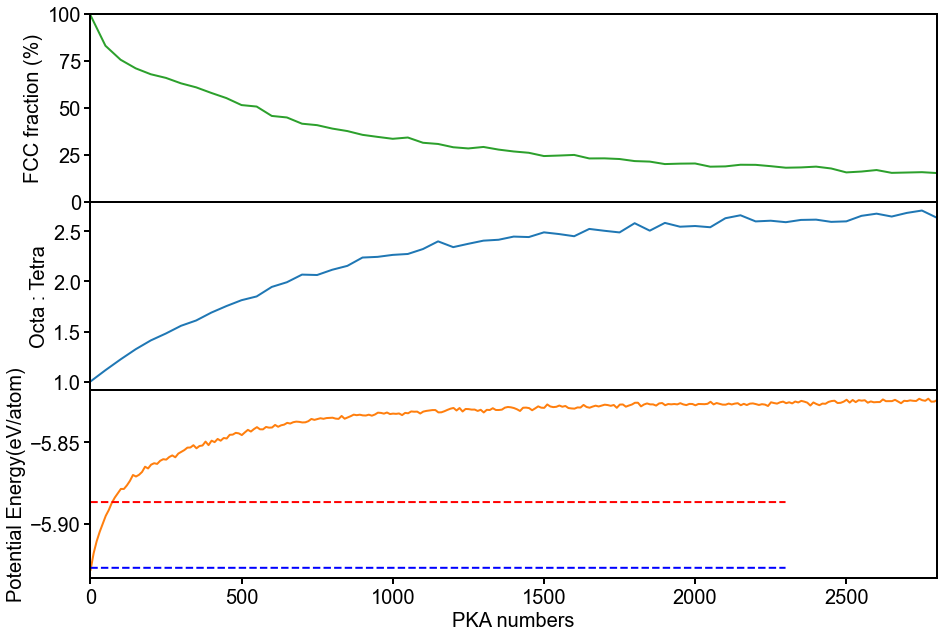

In [16]:
#small box overlap nvt

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs =plt.subplots(3, 1,figsize=(12,8),sharex=True)

pka = [i for i in range(0, 2801, 50)]
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
path='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade/smallbox/'
fn=path+'fcc'
df=pd.read_csv(fn,sep=' ')
df = df.drop(df.columns[-1], axis=1)

df.columns=['tetra','oct','fcc']
axs[0].set_ylim([0,100])
df['o_t']=df['oct']/df['tetra']
df['fcc']=df['fcc']/81920/0.6*100
print(len(df['o_t']))
#plt.plot(df['DPA'],df['o_t'])
axs[0].plot(pka,df['fcc'],linewidth=2,color='C2')
axs[1].plot(pka,df['o_t'],linewidth=2,color='C0')

# Define the folder path for log files
path2 = '/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade/smallbox/log/'

# List all files in the folder ending with .dat
files = [f for f in os.listdir(path2) if f.endswith('.dat')]

# Extract numeric parts from filenames
numbers = [int(re.sub(r'\D', '', f)) for f in files]
# Sort the numbers
numbers.sort()
pkals=[i*10+1 for i in range(len(numbers))]

pe=[]
#print(pka)
for i in numbers:
    fn2=path2+'{}.dat'.format(i)
    log =pd.read_csv(fn2, sep=' ',header=None)
    log.columns=['step','t','T','pe','ke','etotal','Press','v']
    pe.append(list(log['pe'])[-1]/81920)
  
axs[2].plot(pkals,pe,linewidth=2,color='C1')
print(pe[-1],df['fcc'].iloc[-1])
beta=[-485546.0543 /81920 for i in range(2800)]

gamma=[-1220670.514 /207360 for i in range(2800)] 
axs[2].plot(gamma,'--',linewidth=2,color='red')
axs[2].plot(beta,'--',linewidth=2,color='blue')
axs[2].set_xlabel('PKA numbers',fontsize=20)
axs[2].set_xlim([0,2300])
axs[1].set_ylabel('Octa : Tetra',fontsize=20)
axs[0].set_ylabel('FCC fraction (%)',fontsize=20)
axs[2].set_ylabel('Potential Energy(eV/atom)',fontsize=20)
axs[1].grid(False)
# Set the desired x-axis limits
axs[2].set_xlim([0,2800])
axs[0].tick_params( width=2,length=6,labelsize=20)
axs[1].tick_params( width=2,length=6,labelsize=20)
axs[2].tick_params( width=2,length=6,labelsize=20)
#plt.savefig('/Users/ruhe/Desktop/overlapping3-3', format='svg')

500
1000
2405


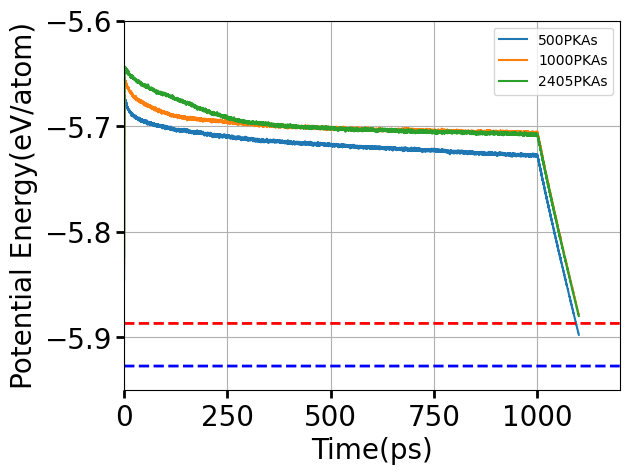

In [4]:
numbers = [500,1000,2405]
for n in numbers:
    fn='//Users/ruhe/Desktop/ga2o3/overlapping/smallbox_without_npt/nvt_anneal/lammps-anneal{}.log'.format(n)
    print(n)
    log = lammps_logfile.File(fn)
    plt.plot(log.get('Time'),log.get("v_ape"),label='{}PKAs'.format(n))
plt.ylim([-5.95,-5.6])
plt.grid()
plt.xlabel('Time(ps)',fontsize=20)
plt.ylabel('Potential Energy(eV/atom)',fontsize=20)
plt.tick_params( width=2,length=6,labelsize=20)
beta=[-485546.0543 /81920 for i in range(1200)]

gamma=[-1220670.514 /207360 for i in range(1200)] 
plt.plot(beta,'--',linewidth=2,color='blue')
plt.plot(gamma,'--',linewidth=2,color='red')
plt.xlim([0,1200])
plt.legend()

500
1000
2405


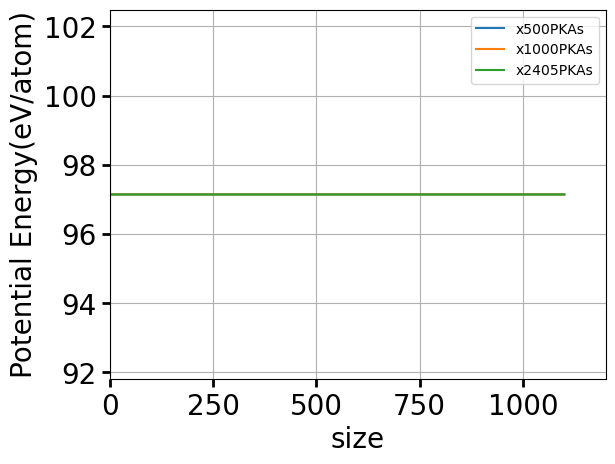

In [8]:
numbers = [500,1000,2405]
for n in numbers:
    fn='//Users/ruhe/Desktop/ga2o3/overlapping/smallbox_without_npt/nvt_anneal/lammps-anneal{}.log'.format(n)
    print(n)
    log = lammps_logfile.File(fn)
    plt.plot(log.get('Time'),log.get("Lx"),label='x{}PKAs'.format(n))
    #plt.plot(log.get('Time'),log.get("Ly"),label='y{}PKAs'.format(n))
    #plt.plot(log.get('Time'),log.get("Lz"),label='z{}PKAs'.format(n))

plt.grid()
plt.xlabel('size',fontsize=20)
plt.ylabel('Potential Energy(eV/atom)',fontsize=20)
plt.tick_params( width=2,length=6,labelsize=20)

plt.xlim([0,1200])
plt.legend()